**Task**

In this exercise, you are given a dataset with claims data. You need to perform an Exploratory Data Analysis and present your results to business users (e.g. interactive dashboard, notebook, or some other tool of your choice).

Business users are interested to see trends and anomalies in the data as well as projections for the upcoming 6 months.



*Note*: Claims are expenses that insurance companies have to pay for medical services provided to patients.



**Dataset**

This dataset is a sampled aggregated data for the period of 2018/01 - 2020/07 (numbers are fictional). 

The dataset contains the following columns:

MONTH - a month claims were lodged
SERVICE_CATEGORY - a department that provided services to patients
CLAIM_SPECIALTY - a type of medical services by an official classification system
PAYER - an insurance company
PAID_AMOUNT - sum of expenses (claims), $


**Requirements**

Python 3+
Open-source libraries
[Optional] Use Docker 


**Hints**

Kaggle EDA’s as a reference
Flask / FastAPI / plotly / bokeh / dash / etc.
Perform any necessary data clean up
For additional interactivity, you can use filtering data on the fly, pivoting data, etc.

**How to submit**

Please upload the code for this project to GitHub, post a link to your repository below and give instructions on how to set up a local environment and run your code.



**Загрузка библиотек**

In [1]:
# Import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

**Загрузка данных**

In [3]:
#Загрузим claims 
df_claims = pd.read_csv('https://docs.google.com/spreadsheets/d/' +
                   '12o1iofQx6V-UhInjUjLjpKxx3Z8ve8EGxnQtzNioIv4' +
                   '/export?gid=0&format=csv')

**Первый взгляд на данные**

In [4]:
df_claims.head()

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,201801,AncillaryFFS,NaN,Payer F,4281
1,201801,AncillaryFFS,NaN,Payer H,2221
2,201801,AncillaryFFS,NaN,Payer O,3937
3,201801,AncillaryFFS,NaN,Payer W,268
4,201801,AncillaryFFS,ACH,Payer W,151


In [5]:
df_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52152 entries, 0 to 52151
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MONTH             52152 non-null  int64 
 1   SERVICE_CATEGORY  52152 non-null  object
 2   CLAIM_SPECIALTY   51901 non-null  object
 3   PAYER             52152 non-null  object
 4   PAID_AMOUNT       52152 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


In [6]:
df_claims.describe().T

,count,mean,std,min,25%,50%,75%,max
MONTH,52152.0,201885.029567,72.867005,201801.0,201808.0,201903.0,201911.0,202007.0
PAID_AMOUNT,52152.0,3708.706934,34498.421938,-42230.0,194.0,586.0,1465.0,2268611.0


In [7]:
df_claims.head(10).T

,0,1,2,3,4,5,6,7,8,9
MONTH,201801,201801,201801,201801,201801,201801,201801,201801,201801,201801
SERVICE_CATEGORY,AncillaryFFS,AncillaryFFS,AncillaryFFS,AncillaryFFS,AncillaryFFS,AncillaryFFS,AncillaryFFS,AncillaryFFS,AncillaryFFS,AncillaryFFS
CLAIM_SPECIALTY,NaN,NaN,NaN,NaN,ACH,Advanced Registered Nurse Prac,ADVANCED RN PRACT,AMBULANCE,AMBULANCE,AMBULANCE
PAYER,Payer F,Payer H,Payer O,Payer W,Payer W,Payer UN,Payer CA,Payer CA,Payer CO,Payer F
PAID_AMOUNT,4281,2221,3937,268,151,0,443,14890,1722,36108


* Пропуски есть только в столбце **CLAIM_SPECIALTY**
* Формат месяца нужно привести к правильному
* Выплаты имеют отрцательные значения




**Проверим данные на явные дубли:**

In [8]:
df_claims.duplicated().sum()

0

* Полных дубликатов не обнаружено.

**Исследуем отдельные признаки ("фичи")**

**Рассмотрим подробнее столбец с месяцем:**

In [9]:
df_claims['MONTH'].value_counts()

201907    1877
201910    1863
201908    1828
201905    1823
201901    1790
202001    1782
201808    1775
201909    1774
201912    1772
202003    1769
201903    1769
201904    1767
201809    1767
201805    1759
201902    1751
201810    1748
201811    1747
201906    1746
201806    1745
201911    1723
201803    1723
201812    1718
201804    1714
201801    1712
202002    1711
201807    1706
202005    1668
201802    1664
202004    1539
202006    1344
202007      67
201900      11
Name: MONTH, dtype: int64

* Видим, что последний месяц имеет всего 67 значений и есть месяц с неправильным указанием 0. Эти два месяца лучше исключить, при проведении стат анализа.


In [10]:
#Исклюим 2 месяца 201900 и 202007:
df_claims = df_claims.query('MONTH != 201900')
df_claims = df_claims.query('MONTH != 202007')
#Добавм два отдельных столбца с месяцем и годом:
u = df_claims['MONTH'].astype(str)
df_claims['Year'], df_claims['Month'] = u.str[:4], u.str[4:]
#Приведем столбец с месяцем к нужному формату:
df_claims['MONTH'] = pd.to_datetime(df_claims['MONTH'], format='%Y%m').dt.strftime('%Y-%m')                              

In [11]:
df_claims.head()

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT,Year,Month
0,2018-01,AncillaryFFS,NaN,Payer F,4281,2018,01
1,2018-01,AncillaryFFS,NaN,Payer H,2221,2018,01
2,2018-01,AncillaryFFS,NaN,Payer O,3937,2018,01
3,2018-01,AncillaryFFS,NaN,Payer W,268,2018,01
4,2018-01,AncillaryFFS,ACH,Payer W,151,2018,01


In [12]:
df_claims.head()

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT,Year,Month
0,2018-01,AncillaryFFS,NaN,Payer F,4281,2018,01
1,2018-01,AncillaryFFS,NaN,Payer H,2221,2018,01
2,2018-01,AncillaryFFS,NaN,Payer O,3937,2018,01
3,2018-01,AncillaryFFS,NaN,Payer W,268,2018,01
4,2018-01,AncillaryFFS,ACH,Payer W,151,2018,01


**Рассмотрим подробнее столбец SERVICE_CATEGORY:**

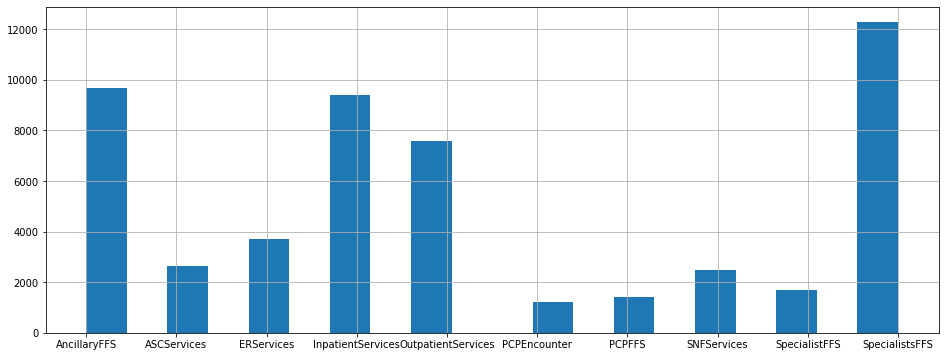

In [13]:
plt.figure(figsize=(16,6))
df_claims['SERVICE_CATEGORY'].hist(bins=(20))

In [14]:
df_claims['SERVICE_CATEGORY'].sort_values().value_counts(normalize=True)

SpecialistsFFS        0.235722
AncillaryFFS          0.185928
InpatientServices     0.180762
OutpatientServices    0.145408
ERServices            0.070861
ASCServices           0.050678
SNFServices           0.047951
SpecialistFFS         0.032339
PCPFFS                0.026904
PCPEncounter          0.023447
Name: SERVICE_CATEGORY, dtype: float64

**Рассмотрим подробнее столбец PAID_AMOUNT:**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


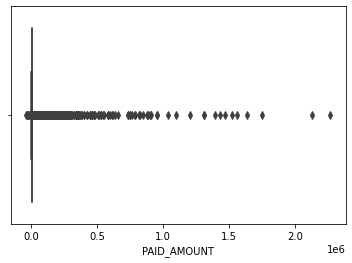

In [15]:
sns.boxplot(df_claims['PAID_AMOUNT'])


In [16]:
df_claims['PAID_AMOUNT'].sort_values()

24512     -42230
13994     -37333
28056     -28562
15756     -28465
12214     -26093
19243     -16290
20971      -7170
268        -5414
16689      -5103
24514      -4438
3560       -4119
50172      -3412
24356      -3343
42491      -3011
42584      -2560
17503      -2537
46004      -2438
18445      -2312
10593      -2022
6198       -1833
3458       -1825
26296      -1740
30809      -1696
26241      -1623
29051      -1597
27249      -1579
6207       -1575
5181       -1549
1757       -1470
25461      -1463
8760       -1463
20175      -1452
8842       -1445
11410      -1411
13828      -1381
49414      -1374
29062      -1280
32633      -1254
1888       -1237
26289      -1201
17332      -1200
45150      -1147
43418      -1125
18438      -1102
47768      -1100
26287      -1055
5245       -1047
9690       -1023
34479      -1022
31639      -1019
7955       -1015
20167      -1000
14952       -972
26274       -954
36960       -953
27916       -945
26291       -944
23698       -918
19159       -9

**Гипотеза, что отрицательные значения это ошибка при занесении и 0 -это нулевые выплаты, что тоже возможно. Поэтому далее отрицательные выплаты преобразуем в положительные, а нулевые оставляем для дальнейшего анализа. Судя по босксплоту есть выбросы и среди положительных выплат, но тут лучше предварительно проконсультироваться с коллегами, чтобы узнать о возможности таких больших выплат.**

In [17]:
#отрицательные выплаты преобразуем в положительные:
df_claims['PAID_AMOUNT'] = df_claims['PAID_AMOUNT'].abs()

**Рассмотрим подробнее столбец CLAIM_SPECIALTY:**

In [18]:
df_claims['CLAIM_SPECIALTY'].value_counts().head(100)

INTERNAL MEDICINE             1227
FAMILY PRACTICE               1128
GENERAL PRACTICE               949
GENERAL SURGERY                806
PATHOLOGY                      772
RADIOLOGY                      768
CARDIOLOGY                     749
GASTROENTEROLOGY               714
ANESTHESIOLOGY                 685
ORTHOPEDIC SURGERY             624
NEPHROLOGY                     617
PODIATRY                       609
PAIN MANAGEMENT                605
UROLOGY                        580
NEUROLOGY                      568
HEMATOLOGY/ONCOLOGY            539
INTERVENTIONAL CARDIOLOGY      539
HOSPITAL                       521
Internal Medicine              503
HOSPITALIST                    479
ONCOLOGY                       474
VASCULAR SURGERY               447
CARDIAC ELECTROPHYSIOLOGY      399
OBSTETRICS & GYNECOLOGY        395
ENT                            385
ENDOCRINOLOGY                  385
Family Practice                384
Gastroenterology               383
DIAGNOSTIC RADIOLOGY

**Посмотрим ТОП 10 по частоте**

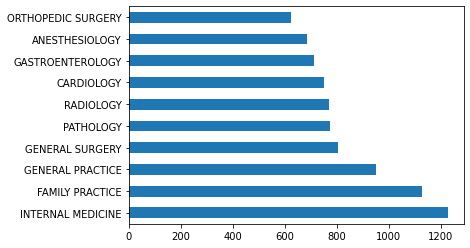

In [19]:
df_claims['CLAIM_SPECIALTY'].value_counts().head(10).plot(kind='barh')

**Посмотрим количество уникальных специальностей (записей в столбце CLAIM_SPECIALTY)**

In [20]:
df_claims['CLAIM_SPECIALTY'].nunique()

905

**Приведем все к нижнему регистру, чтобы уменьшить вариации в написании. Пересоставим ТОП 10 и перепровреим кол-во уникальных специальностей (записей в столбце CLAIM_SPECIALTY)**

In [21]:
df_claims['CLAIM_SPECIALTY'] = df_claims['CLAIM_SPECIALTY'].str.lower()

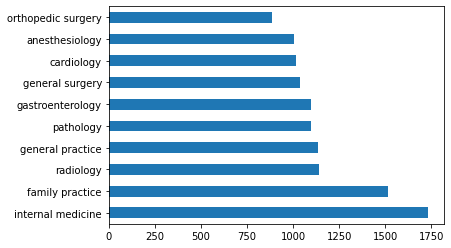

In [22]:
df_claims['CLAIM_SPECIALTY'].value_counts().head(10).plot(kind='barh')

In [23]:
df_claims['CLAIM_SPECIALTY'].nunique()

794

**После преобразования, кол-во уникальных записей уменьшилось, значит мы сделали все верно. В данном столбце можно сделать доп преобразования, но предварительно уточнив некоторые сокращения.**

In [24]:
df_claims.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52074 entries, 0 to 52084
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MONTH             52074 non-null  object
 1   SERVICE_CATEGORY  52074 non-null  object
 2   CLAIM_SPECIALTY   51823 non-null  object
 3   PAYER             52074 non-null  object
 4   PAID_AMOUNT       52074 non-null  int64 
 5   Year              52074 non-null  object
 6   Month             52074 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.2+ MB


In [25]:
#Преобразуем столбцы с месяцем и годом в числовой формат.
df_claims['Month'] = df_claims['Month'].astype('int')
df_claims['Year'] = df_claims['Year'].astype('int')

**Проверим еще раз на дубликаты после преобразований:**

In [26]:
df_claims.duplicated().sum()

0

**Исследуем признаки совместно**

In [27]:
df_claims.head()

,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT,Year,Month
0,2018-01,AncillaryFFS,NaN,Payer F,4281,2018,1
1,2018-01,AncillaryFFS,NaN,Payer H,2221,2018,1
2,2018-01,AncillaryFFS,NaN,Payer O,3937,2018,1
3,2018-01,AncillaryFFS,NaN,Payer W,268,2018,1
4,2018-01,AncillaryFFS,ach,Payer W,151,2018,1


**Помотрим на какие сервисы ушло больше всего выплат за указанный период:**

In [28]:
df_claims.groupby(['SERVICE_CATEGORY'])['PAID_AMOUNT'].sum()

SERVICE_CATEGORY
ASCServices            5186366
AncillaryFFS          19773983
ERServices            11765179
InpatientServices     87829236
OutpatientServices    22929066
PCPEncounter             72594
PCPFFS                 3888872
SNFServices            8225118
SpecialistFFS          2005359
SpecialistsFFS        32319772
Name: PAID_AMOUNT, dtype: int64

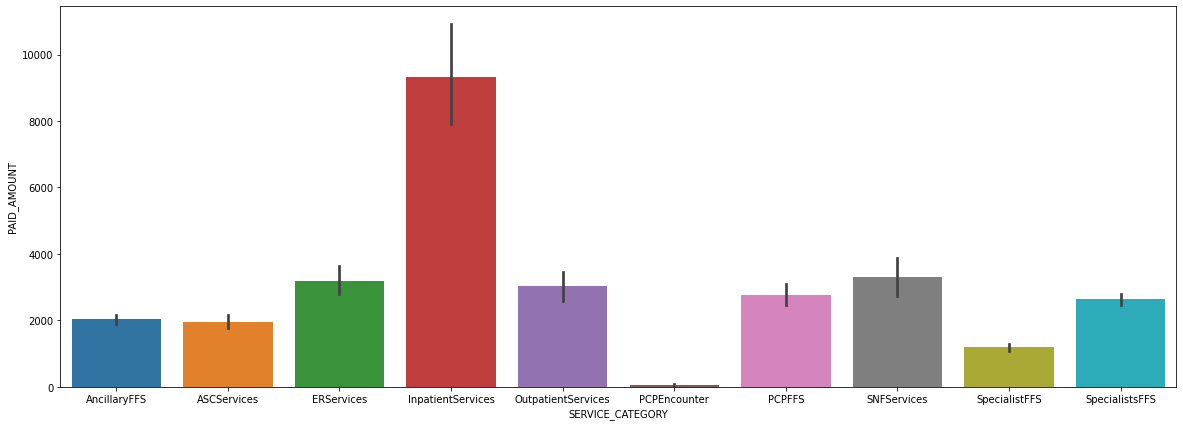

In [29]:
plt.subplots(figsize = (20,7))
sns.barplot(data=df_claims, x="SERVICE_CATEGORY", y="PAID_AMOUNT")



**InpatientServices - является явным лидером по выплатам**

**Посмотрим на суммарные выплаты по месяцам в разрезе сервисов**

(0.0, 15000.0)

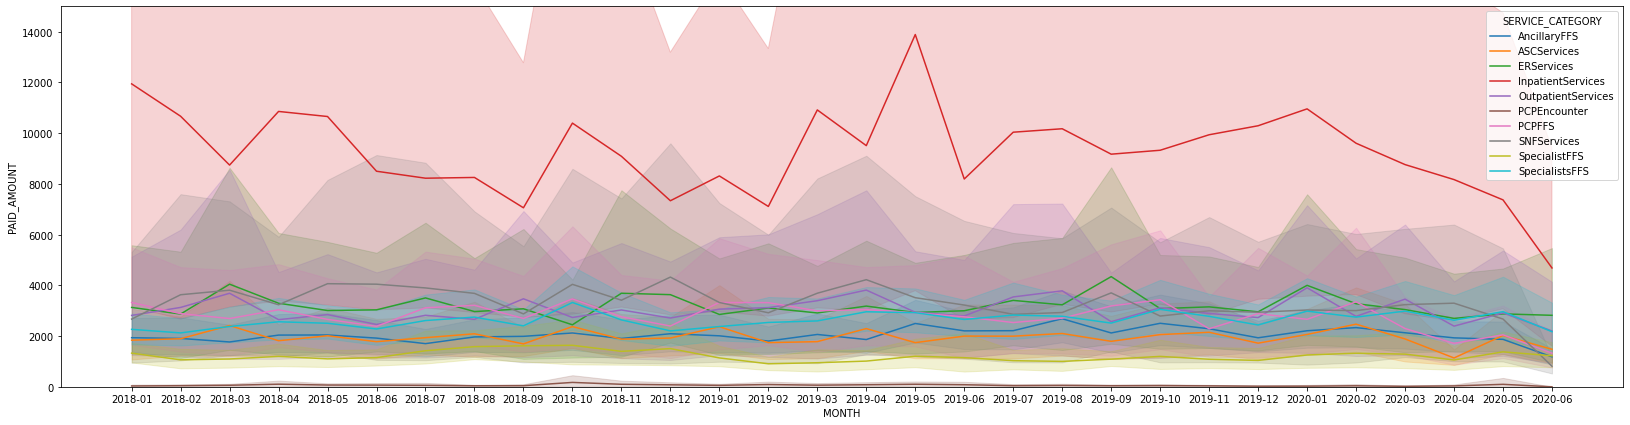

In [30]:
plt.subplots(figsize = (28,7))
sns.lineplot(data=df_claims, x='MONTH', y='PAID_AMOUNT', hue='SERVICE_CATEGORY')
plt.gca().set_ylim(0, 15000)

**Посмотрим на суммарные выплаты по месяцам**

Text(0.5, 1.0, 'Projection of Paid Amount Over Time')

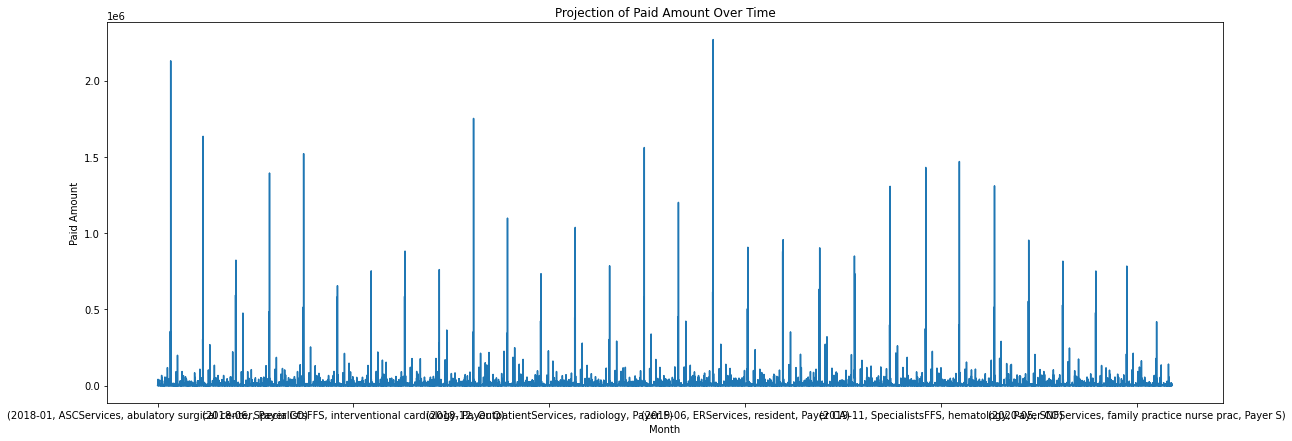

In [31]:
plt.subplots(figsize = (20,7))
df_claims.groupby(['MONTH', 'SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER'])['PAID_AMOUNT'].sum().plot(kind='line')
# Add labels and title to the plot
plt.xlabel('Month')
plt.ylabel('Paid Amount')
plt.title('Projection of Paid Amount Over Time')

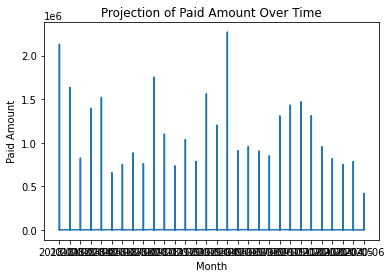

In [32]:
# Plot the paid amount over time
plt.plot(df_claims['MONTH'], df_claims['PAID_AMOUNT'])

# Add labels and title to the plot
plt.xlabel('Month')
plt.ylabel('Paid Amount')
plt.title('Projection of Paid Amount Over Time')

# Show the plot
plt.show()


Text(0.5, 1.0, 'Projection of Paid Amount Over Time')

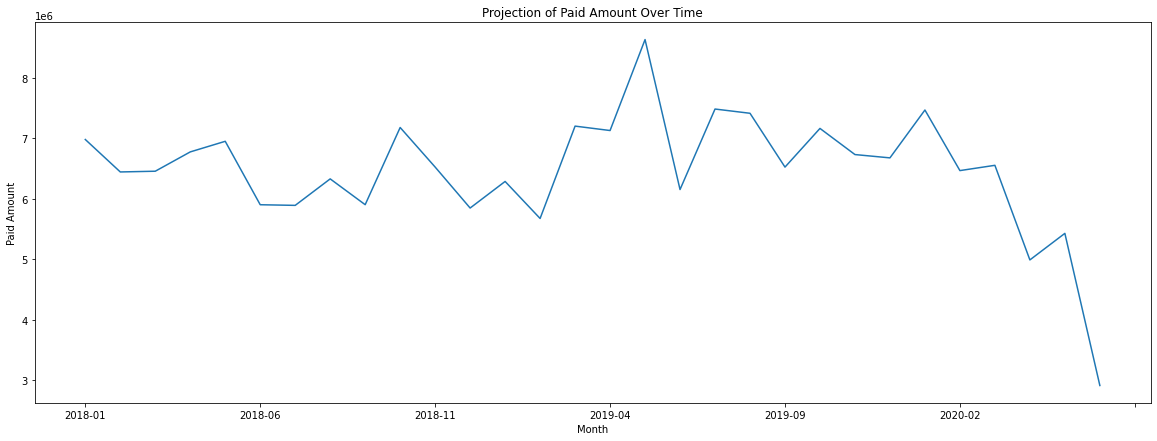

In [33]:
plt.subplots(figsize = (20,7))
df_claims.groupby(['MONTH'])['PAID_AMOUNT'].sum().plot()
# Add labels and title to the plot
plt.xlabel('Month')
plt.ylabel('Paid Amount')
plt.title('Projection of Paid Amount Over Time')

**По графикам выше можно увидеть тренд на снижение суммарных выплат начиная с 2020 года**

**Построим график прогноза суммарных выплат на следующие 6 месяцев:**

In [39]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 30 and height to 10
fig_size[0] = 30
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


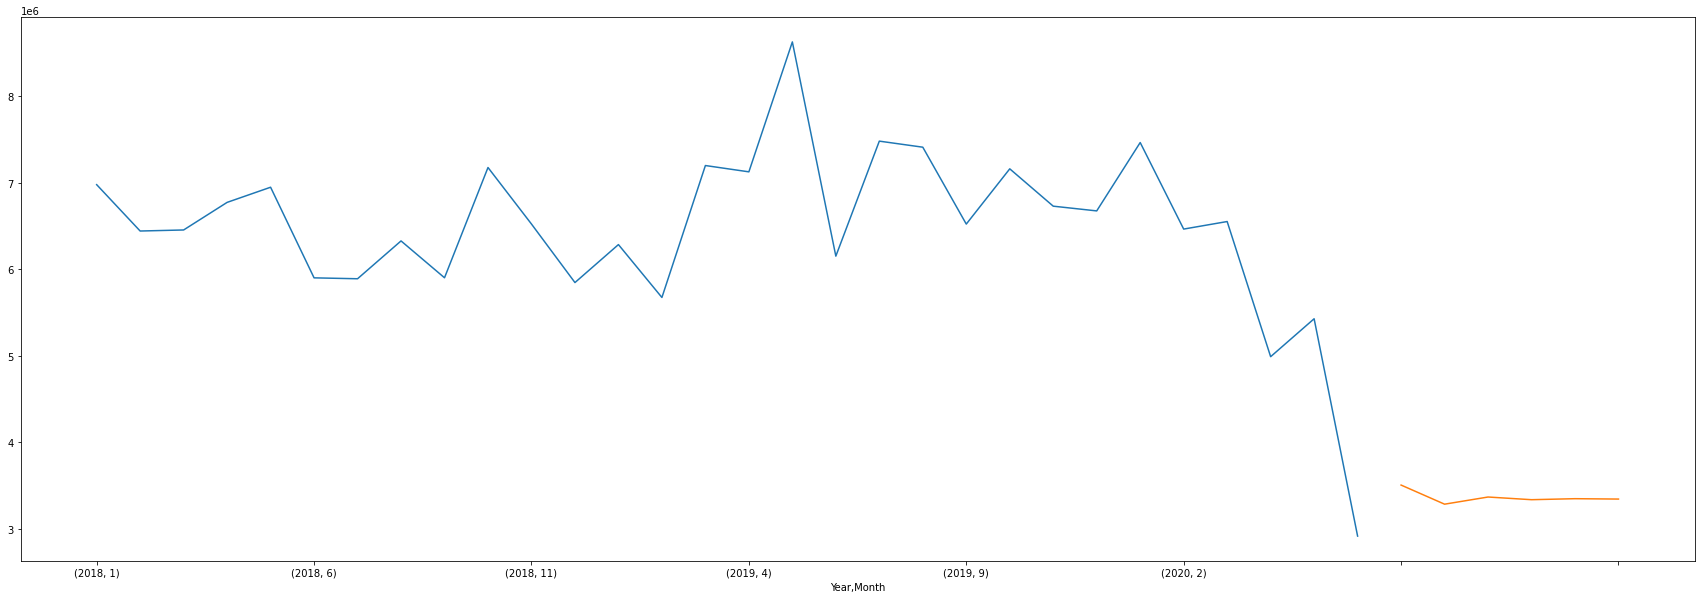

In [40]:
# Train an ARIMA model on the 'PAID_AMOUNT' column
model = ARIMA(df_claims.groupby(['Year','Month'])['PAID_AMOUNT'].sum(), order=(1,1,1))
model_fit = model.fit()
# Make predictions for the next 6 months
predictions = model_fit.forecast(steps=6)
df_claims.groupby(['Year','Month'])['PAID_AMOUNT'].sum().plot()
predictions.plot(kind='line')

**Согласно прогнозу, выплаты на следующие 6 месяцев будут на довольно низком уровне от 3х до 4х млн.**

# **Проведем дополнительный анализ**





In [35]:
#Сгруппируем по меясцам и сохраним в отдельный датафрейм:
df_grouped = df_claims.groupby('MONTH')['PAID_AMOUNT'].sum().reset_index()
df_grouped = df_grouped.set_index('MONTH')

**Посторим график сезонности, тренда и шума**

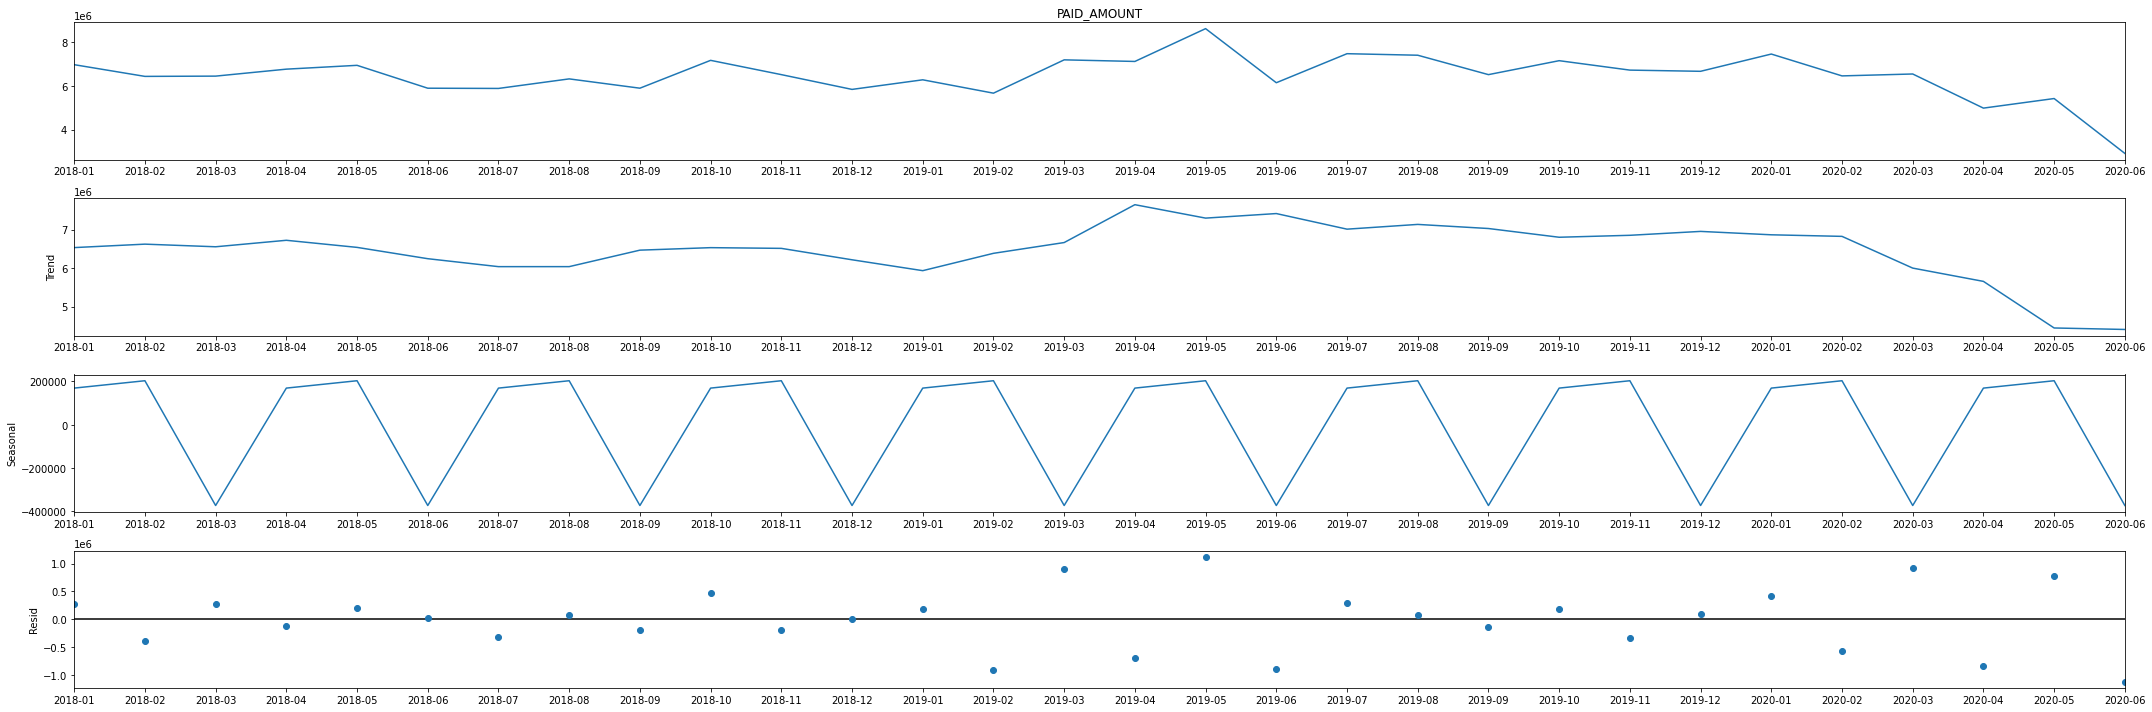

In [37]:
paid_amount_decompose_result = seasonal_decompose(df_grouped['PAID_AMOUNT'], model='additive',extrapolate_trend='freq', period=3)
paid_amount_decompose_result.plot()
plt.show()

Наблюдается сезонность

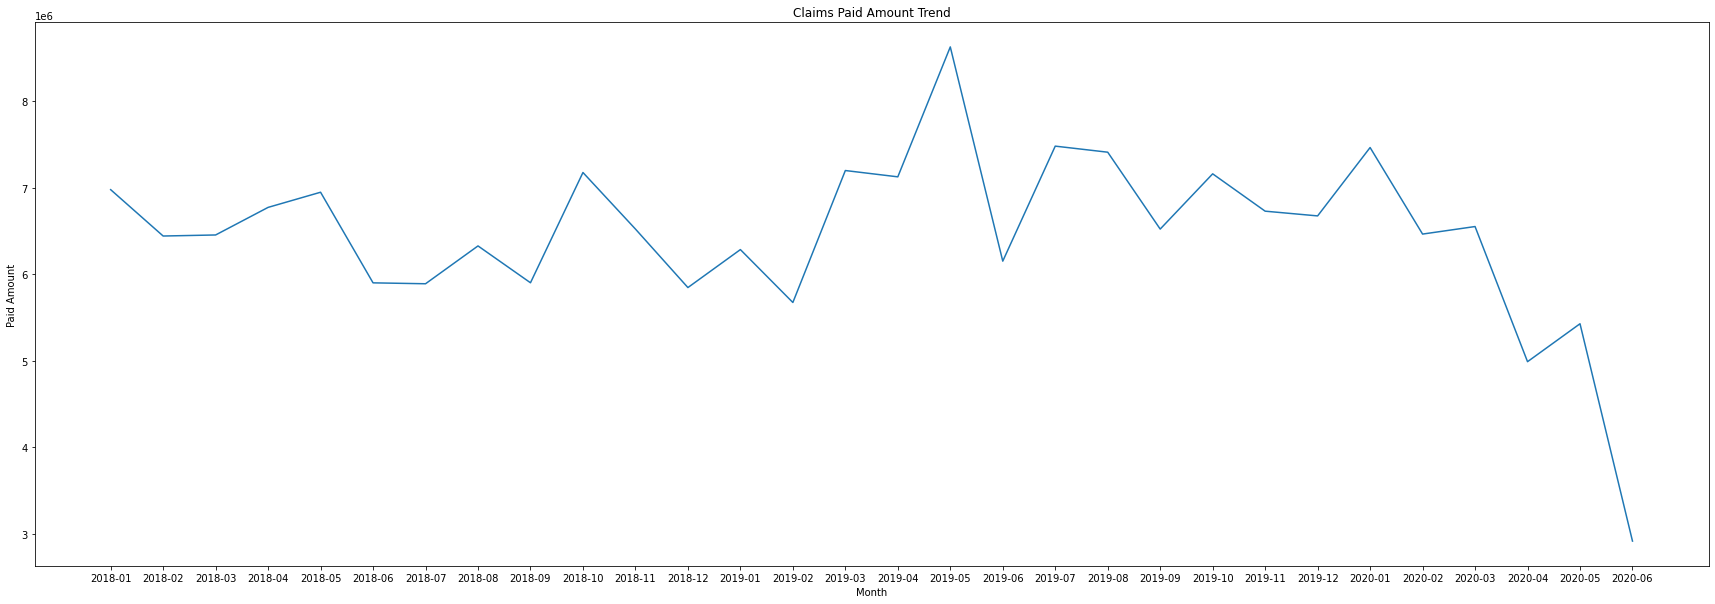

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/l

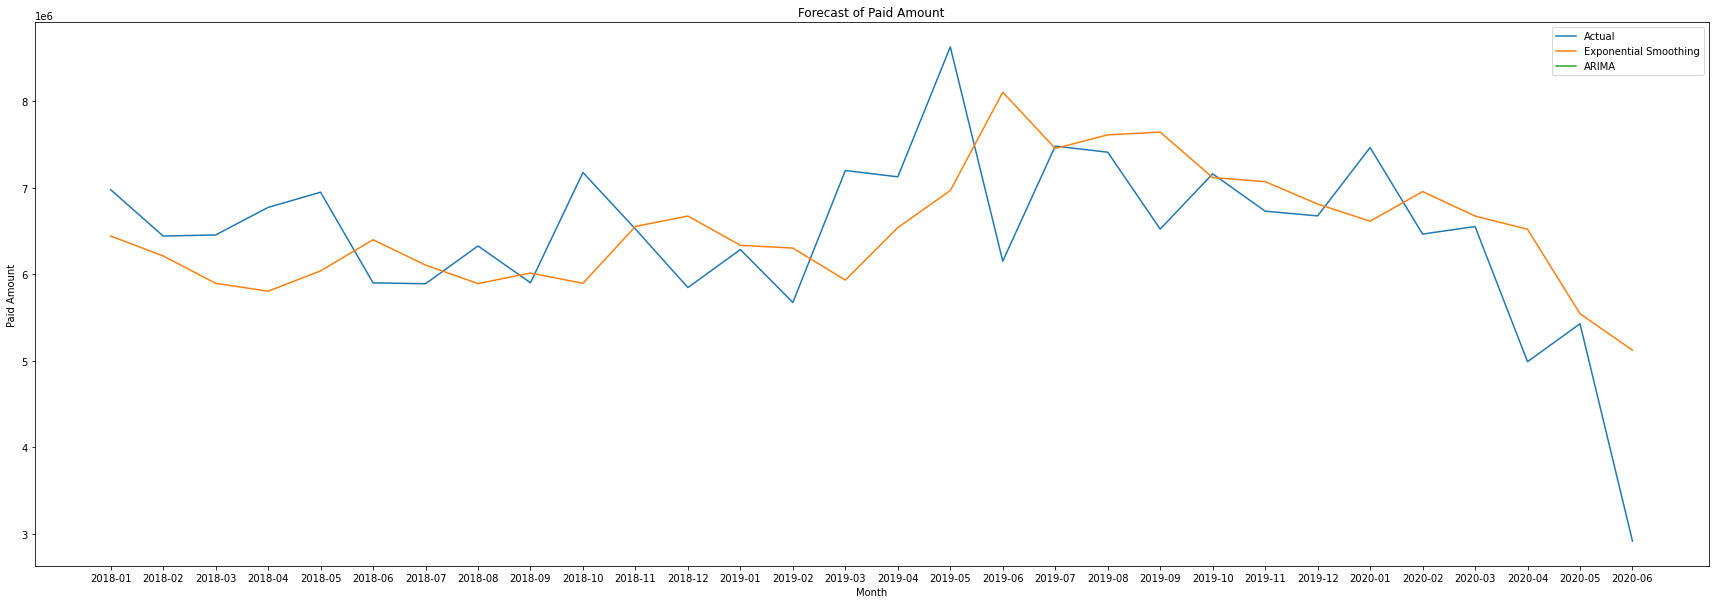

In [38]:
# Visualize the data using line plot
plt.plot(df_grouped['PAID_AMOUNT'])
plt.xlabel('Month')
plt.ylabel('Paid Amount')
plt.title('Claims Paid Amount Trend')
plt.show()

# Forecast using Moving Average
MA = df_grouped.rolling(window=12).mean()
#df['MA'] = MA

# Forecast using Exponential Smoothing
model = ExponentialSmoothing(df_grouped['PAID_AMOUNT'], trend='add')
fit = model.fit()
df_grouped['ES'] = fit.fittedvalues

# Forecast using ARIMA
model = ARIMA(df_grouped['PAID_AMOUNT'], order=(1,1,1))
fit = model.fit()
df_grouped['ARIMA'] = fit.predict(start=len(df_grouped), end=len(df_grouped)+6, dynamic=False)

# Plot the actual values and predicted values
plt.plot(df_grouped['PAID_AMOUNT'], label='Actual')
#plt.plot(df['MA'], label='Moving Average')
plt.plot(df_grouped['ES'], label='Exponential Smoothing')
plt.plot(df_grouped['ARIMA'], label='ARIMA')
plt.xlabel('Month')
plt.ylabel('Paid Amount')
plt.title('Forecast of Paid Amount')
plt.legend()
plt.show()

# Выводы и найденные аномалии в данных:

* Пропуски есть только в столбце CLAIM_SPECIALTY
* Формат месяца нужно привести к правильному
* Выплаты содержат отрицательные значения - (возможно ошибка при занесении, занесли со знаком минус). Так же нужны уточнения для определения положительных выбросов.
* Явных дубликатов не обнаружено
* Последний месяц 202007 имеет всего 67 значений и есть месяц с неправильным указанием 201900. Эти два месяца лучше исключить, при проведении стат анализа.
* Стодбец CLAIM_SPECIALTY содержит разное написание одних и тех же специальностей, приведение к нижнему регистру уменьшило кол-во уникальных записей, но еще осталась возможность для улучшения.
* InpatientServices - является явным лидером по выплатам
* По графикам выше можно увидеть тренд на снижение суммарных выплат начиная с 2020 года
* Наблюдается сезонность
* Согласно прогнозу, выплаты на следующие 6 месяцев будут на довольно низком уровне от 3х до 4х млн.

